In [1]:
import os
import sys

# Change this value to the path of the reco-engine repository on your machine
REPO_FOLDER = "perso/job-talent-matching-engine"
sys.path.append(os.path.join(os.path.expanduser("~"), REPO_FOLDER))

In [2]:
import joblib
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from src import constants
from src.utils import features_extraction

# Data processing

In [3]:
with open(constants.DATA_FILE_PATH, "r") as data_file:
    batch = json.load(data_file)

## Dataset computation

In [4]:
# Instantiate the FeaturesExtractor class
features_extractor = features_extraction.FeaturesExtractor()

# Compute the dataset
dataset = features_extractor.get_dataset(batch)

In [5]:
dataset.head()

,must_have_languages_overlap,optional_languages_spoken,job_roles_overlap,job_roles_number,talent_has_seniority_requirement,talent_has_min_degree_requirement,salary_expectation_matches_offer,salary_expectation_gap,label
0,1.0,2,1.0,1,True,True,True,22000,True
1,1.0,2,1.0,1,True,True,True,26000,True
2,1.0,2,1.0,1,True,True,True,25000,True
3,1.0,0,1.0,1,True,True,True,24000,True
4,1.0,1,1.0,2,True,True,True,5000,True


## Correlogram

In [6]:
dataset.corr()[["label"]].style.background_gradient(cmap="coolwarm")

,label
must_have_languages_overlap,0.587779
optional_languages_spoken,-0.020795
job_roles_overlap,0.613704
job_roles_number,-0.022263
talent_has_seniority_requirement,0.640654
talent_has_min_degree_requirement,0.647647
salary_expectation_matches_offer,0.481447
salary_expectation_gap,0.529170
label,1.000000


The `job_roles_number` & `optional_languages_spoken` are barely correlated to the target variable, we may not expect them to have a big predictive power compared to other features

In [7]:
dataset["label"].value_counts()

label
True     1000
False    1000
Name: count, dtype: int64

The labels in the dataset are completely balanced so we can choose the **accuracy** as our evaluation metric, otherwise the **F1 Score** would have been a wiser choice

## Train

In this section we will choose a **Tree-based** model as we have many boolean/categorical features, a model like a **Random Forest** seems adapted to find the right combination and thresholds between our features to predict whether this the talent and the job are going to be a great match or not. Also a Random Forest algorithm provides more stability than a simple decision tree that can have a lot of variance alone. Combining several trees using the **bagging method** implemented in the Random Forest algorithm allows us to reduce this variance, hence a lower **risk** and a better performance in the end.

In [8]:
X = dataset.drop(columns=["label"]).values
y = dataset["label"].values

# Train-test split : we train on 80% of the data available and evaluate on the remaining 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize & train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict labels for the test set
y_pred = model.predict(X_test)

# Evaluate model performances on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9975


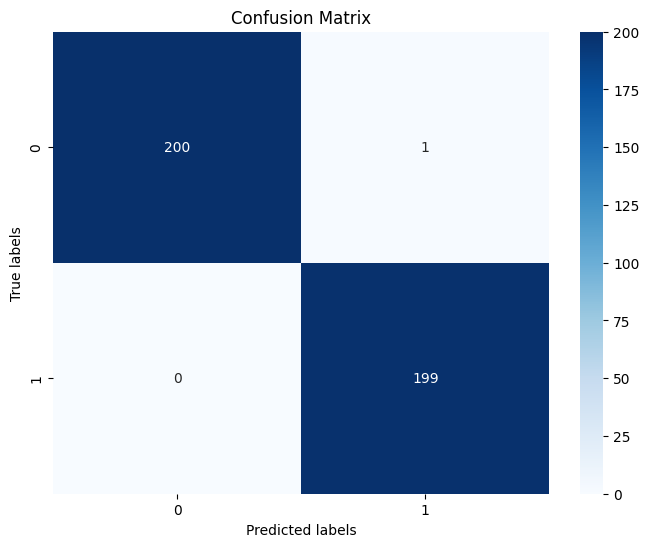

In [9]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

The model has a pretty good performance, having only 1 misclassified sample (a false negative). The model is able to predict the label of the samples with an accuracy of 99.75%.

### Feature importance

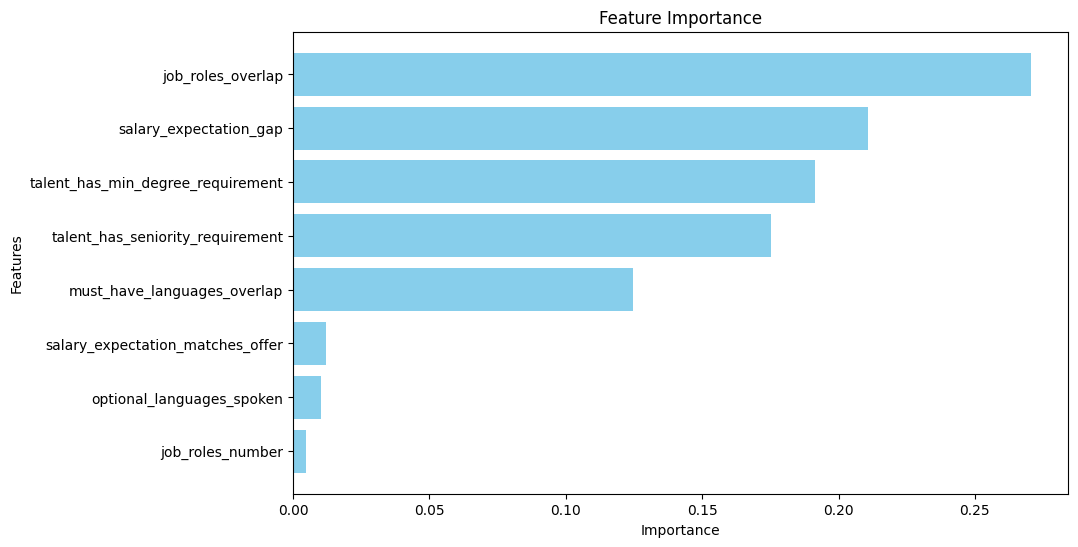

In [10]:
feature_importance_df = pd.DataFrame(
    model.feature_importances_,
    index=[col for col in dataset.columns if col != "label"],
    columns=["Importance"],
)
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df.index, feature_importance_df["Importance"], color="skyblue"
)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

As expected from what we saw with the correlogram : the `job_roles_number` and `optional_languages_spoken` don't play an important part in the predictive task. Also the `salary_expectation_matches_offer` feature doesn't seem really important, as it is highly correlated to `salary_expectation_gap` feature that is the second most important feature according to this graph. We could remove these 3 features, but as the model already performs very well there is not much to gain from doing it, as it is not really time-consuming in the feature engineering phase either

### Save model to disk

In [11]:
joblib.dump(model, constants.MODEL_FILE_PATH)

['/home/guillaume/perso/job-talent-matching/data/model.joblib']